# Estimating $k_j$

>Next, I'd get it working with less and less information assumed to be known. You could either start inferring the participant's stage of disease or the order for biomarkers next. I'd probably do the participant's state of disease.

>For the stage of disease for a participant, I'd do probably derive a gibbs sampling step by calculating each stage's relative likelihood based on the probabilities of the biomarker values ASSUMING they are at that stage. Then you normalize and sample from that discrete distribution.  

## Known $\theta$ and $\phi$

First, let us assume that we know $\theta$ and $\phi$. We also know at which disease stage a biomarker is affected. Basically, in the `data` below, we do not have these two columns: `k_j` and `affected_or_not`. 

For each participant, I will iterate through all possible stages. For each stage, I will calculate the likelihood of seeing the observed biomarker sequence of values using the following formula:

$$p(X_{j} | S , z_j = 1, k_j) = \prod_{i=1}^{k_j}{p(X_{S(i)j} \mid \theta_n )} \prod_{i=k_j+1}^N{p(X_{S(i)j} \mid \phi_n)}$$

Then the stage associated with the maximum likelihood will be the estimated disease stage for this participant. 


In [1]:
import pandas as pd 
import numpy as np 
import re 
import altair as alt 
import matplotlib.pyplot as plt 
data = pd.read_csv('data/participant_data.csv')
data.Biomarker = [re.sub("Biomarker ", "", text) for text in data.Biomarker.tolist()]
data.head()
# but remember that we do not know k_j which is what we are trying to estimate. 

,Biomarker,participant,measurement,k_j,S_n,affected_or_not
0,0,0,10.336151,1,5,not_affected
1,0,1,10.865467,1,5,not_affected
2,0,2,1.238857,7,5,affected
3,0,3,10.163485,2,5,not_affected
4,0,4,11.036735,0,5,not_affected


Note that in `participant_data.csv`, $S_n \geq 1$ because $S_n$ means the disease stage associated with a specific biomarker. $k_j \geq 0$, indicating that participants may not be in any of the 10 disease stages. 

In [2]:
data.S_n.unique()

array([ 5,  7,  6,  4,  8,  2,  9, 10,  1,  3])

In [3]:
data.k_j.unique()

array([ 1,  7,  2,  0,  3,  5, 10,  8,  4,  6,  9])

In [4]:
theta_phi = pd.read_csv('data/means_vars.csv')
theta_phi.head()

,biomarker,theta_mean,theta_var,phi_mean,phi_var
0,0,1.0,0.3,12.0,1.3
1,1,3.0,0.5,11.0,2.4
2,2,5.0,0.2,14.0,1.4
3,3,6.0,1.3,16.0,0.9
4,4,8.0,3.3,18.0,1.5


In [5]:
def compute_likelihood(theta_phi, biomarker, affected, measurement):
    '''Computes the likelihood of the given measurement data
    We know the normal distribution defined by either theta or phi
    and we know the measurement. This will give us the probability
    of the given measurement. 

    input:
    - theta_phi: the dataframe containing theta and phi values for each biomarker
    - biomarker: an integer between 0 and 9 
    - affected: boolean 
    - measurement: the observed value for a biomarker in a specific participant

    output: a number 
    '''
    biomarker_params = theta_phi[theta_phi.biomarker == biomarker].reset_index()
    mu = biomarker_params['theta_mean'][0] if affected else biomarker_params['phi_mean'][0]
    var = biomarker_params['theta_var'][0] if affected else biomarker_params['phi_var'][0]
    sigma = np.sqrt(var)
    return np.exp(-(measurement - mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)

In [6]:
# Disable scientific notation
np.set_printoptions(suppress=True)

# biomarkers: [0, 9]
biomarkers = np.arange(start = 0, stop = 10, step = 1)
participants = data.participant.unique()
num_iterations = 1000
# 11 stages in total, [0, 10]. We need to + 1 because there is no 
num_stages = len(data.S_n.unique())
estimated_stage_dic = {}
actual_stage_dic = {}

# stages = np.random.randint(0, num_stages, len(participants))

for p in participants:
    p_data = data[data.participant == p].reset_index(drop=True)
    actual_stage_dic[p] = p_data.k_j[0]
    stage_likelihood = np.zeros(num_stages + 1)
    # assume participant is in this stage; compute the likelihood of seeing 
    # this sequence of observed biomarker measuremen
    # [0, 10] Note that k CAN be 0
    for k in range(num_stages + 1):
        likelihood = 1
        for biomarker in biomarkers:
            biomaker_data = p_data[p_data.Biomarker == str(biomarker)].reset_index(drop=True)
            measurement = biomaker_data.measurement[0]
            biomarker_stage = biomaker_data.S_n[0]
            affected = k >= biomarker_stage
            # the final updated likelihood is the likelihood of seeing 
            # this sequence of data of the total number of biomarkers 

            # This is using the equation here: https://ebm-book2.vercel.app/distributions.html#known-k-j
            likelihood *= compute_likelihood(
                theta_phi, biomarker, affected, measurement
            )

            # if the participant is in this stage, what is the likelihood of seeing this 
            # sequence of values
            stage_likelihood[k] = likelihood
    # if p % 10 == 0:
    #     print(stage_likelihood)
    # has_duplicates = len(stage_likelihood) != len(set(stage_likelihood))
    # print(has_duplicates)
    max_likelihood_stage = pd.Series(stage_likelihood).idxmax()
    estimated_stage_dic[p] = max_likelihood_stage           

In [7]:
estimated_stages = np.array(list(estimated_stage_dic.values()))
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages

In [8]:
def scatter_plot_of_stage_differences(stage_differences):
    '''Scatter Plot of the Difference at each index
    Input:
    - stage_differences: estimated_stages - actual stages. Result should be a 1-dim np array
    '''
    plt.figure(figsize=(10, 6))
    plt.scatter(range(100), stage_differences, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Scatter Plot of Stage Difference for Each Participant")
    plt.xlabel("Participant")
    plt.ylabel("Difference (Estimated Stage - True Stage)")
    plt.grid(True)
    plt.show()

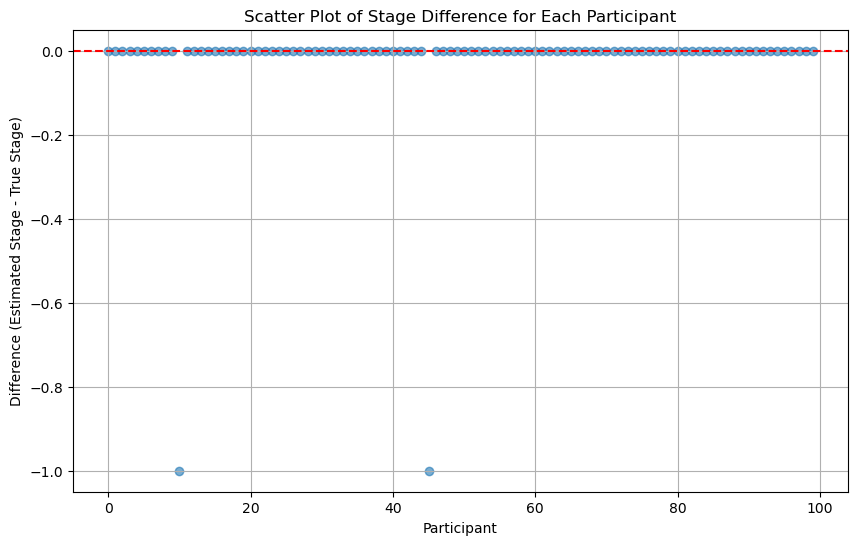

In [9]:
scatter_plot_of_stage_differences(differences)


From the above figure, it is clear that the method we employed is effective as it successfully estimated the stage each participant is in.

## Unknown $\theta$ and $\phi$

Suppose we do not have access to the parameters for biomarker value distributions; i.e., we do not know $\theta$ and $\phi$. 

In [10]:
data_we_have = data.drop(['k_j', 'affected_or_not'], axis = 1)
data_we_have.head()

,Biomarker,participant,measurement,S_n
0,0,0,10.336151,5
1,0,1,10.865467,5
2,0,2,1.238857,5
3,0,3,10.163485,5
4,0,4,11.036735,5


In [11]:
def fill_up_data_we_have(data_we_have, participant_stages):
    '''This is to fill up data_we_have. 
    Basically, add two columns: k_j, and affected, based on initial or updated participant_stages

    Essentially, all we do below is to get the most accurate participant_stages
    '''
    participant_stage_dic = dict(zip(np.arange(0,len(participants)), participant_stages))
    data_we_have['k_j'] = data_we_have.apply(lambda row: participant_stage_dic[row.participant], axis = 1)
    data_we_have['affected'] = data_we_have.apply(lambda row: row.k_j >= row.S_n, axis = 1)
    return data_we_have 

In [12]:
def estimate_params_exact(m0, n0, s0_sq, v0, data):
    '''
    data: a vector of measurements. It is of a specific biomarker and of a specific type (affected, or not affected)
    '''
    # Data summary
    sample_mean = np.mean(data)
    sample_size = len(data)
    sample_var = np.var(data, ddof=1)  # ddof=1 for unbiased estimator

    # Update hyperparameters for the Normal-Inverse Gamma posterior
    updated_m0 = (n0 * m0 + sample_size * sample_mean) / (n0 + sample_size)
    updated_n0 = n0 + sample_size
    updated_v0 = v0 + sample_size 
    updated_s0_sq = (1 / updated_v0) * ((sample_size - 1) * sample_var + v0 * s0_sq + 
                    (n0 * sample_size / updated_n0) * (sample_mean - m0)**2)
    updated_alpha = updated_v0/2
    updated_beta = updated_v0*updated_s0_sq/2

    # Posterior estimates
    mu_posterior_mean = updated_m0
    sigma_squared_posterior_mean = updated_beta/updated_alpha

    return mu_posterior_mean, sigma_squared_posterior_mean

In [13]:
def get_estimated_means_vars_df(biomarkers, data_we_have):
    '''To get estimated parameters, returns a Pandas DataFrame
    Input:
    - biomarkers: 0-9
    - data_we_have: participants data filled with initial or updated participant_stages

    Output: 
    - estimate_means_vars_df, just like means_vars_df, containing the estimated mean and var for 
      distribution of biomarker values when the biomarker is affected and not affected

    Special note: 
    '''
    # empty list of dictionaries to store the estimates 
    means_vars_estimate_dict_list = []
    for biomarker in biomarkers: 
        dic = {'biomarker': biomarker}  # Initialize dictionary outside the inner loop
        for affected in [True, False]:
            data_full = data_we_have[(data_we_have.Biomarker == str(biomarker)) & (
            data_we_have.affected == affected)]
            data = np.array(data_full.measurement)
            # if len(data) == 0:
            #     print(data_full)
            mu_estimate, var_estimate = estimate_params_exact(
                m0 = 0, n0 = 1, s0_sq = 1, v0 = 1, data=data)
            if affected:
                dic['theta_mean'] = mu_estimate
                dic['theta_var'] = var_estimate
            else:
                dic['phi_mean'] = mu_estimate
                dic['phi_var'] = var_estimate
        means_vars_estimate_dict_list.append(dic)
    estimate_means_vars_df = pd.DataFrame(means_vars_estimate_dict_list)
    return estimate_means_vars_df 

### Initialization 

In [14]:
biomarkers = np.arange(start = 0, stop = 10, step = 1)
participants = data.participant.unique()
num_iterations = 3
num_stages = len(data_we_have.S_n.unique())
# initialize participant_stages 
# note that high should be num_stages + 1; otherwise, no participants will be in the stage of 10
participant_stages = np.random.randint(low = 0, high = num_stages+1, size = len(participants))

### Randomized initilization result

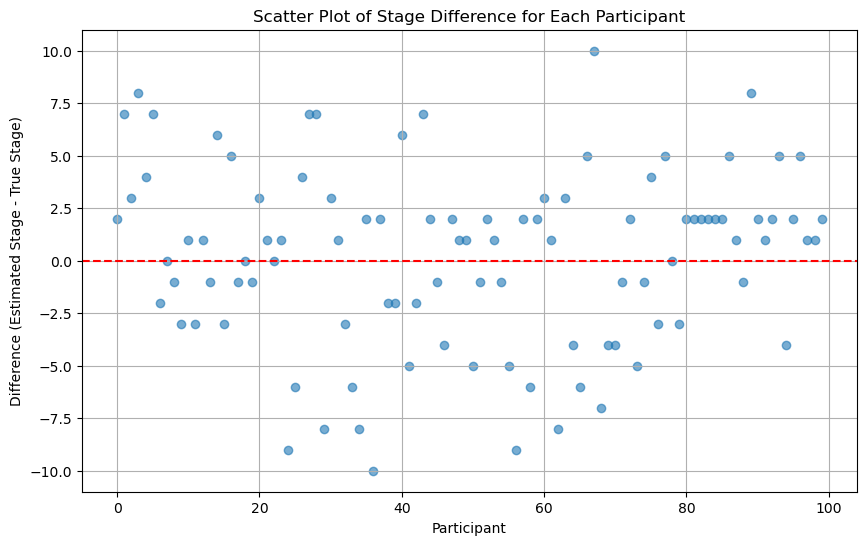

In [15]:
estimated_stages = participant_stages
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages

scatter_plot_of_stage_differences(differences)

### Edge cases

When running the function `get_estimated_means_vars_df`, an edge case exists when a biomarker (Say, Biomarker $T$) indicates stage 1. In the initial set-up, since we randomized participant_stages, some participants might be in stage 0. Therefore, for this biomarker, it has both affected and not affected cases. However, this edge case  exists in later iterations where I cannot ensure that the updated `participant_stages` still contains 0. In those scenarios, this biomarker does not have not affected cases. That is to say, in `data_we_have` filled up by that `participant_stages`, the `k_j` column has no values of $0$. 

Why would this cause issues? Suppose no participants are in stage $0$. Then rows where Biomarker $T$ resides have no `False` in the column of `affected`. Because `estimated_means_vars_df` is obtained from `data_we_have` which is in turn based upon `participant_stages`, `estimated_means_vars_df` does not have values for phi for Biomarker $T$. Then in the following codes, in the `for` loop of `for k in range(num_stages + 1)`, when `k = 0` and `biomarker = T`, we have `affected = False`. When computing `likelihood` there will be an issue because in `estimated_means_vars_df`, there are no `phi` values for biomarker $T$.

I haven't figured out how to solve this issue. 

In [16]:
# import warnings
# warnings.filterwarnings('ignore')

for i in range(num_iterations):
    # fill up data_we_have with the current participant_stages
    data_we_have = fill_up_data_we_have(data_we_have, participant_stages)
    estimated_means_vars_df = get_estimated_means_vars_df(biomarkers, data_we_have)
    for p in participants:
        p_data = data_we_have[data_we_have.participant == p].reset_index(drop=True)
        stage_likelihood = np.zeros(num_stages + 1)
        # note that it should be [0, 10]
        for k in range(num_stages + 1):
            likelihood = 1
            for biomarker in biomarkers:
                # biomarker data for this participant
                p_biomaker_data = p_data[
                    p_data.Biomarker == str(biomarker)
                ].reset_index(drop=True)
                measurement = p_biomaker_data.measurement[0]
                biomarker_stage = p_biomaker_data.S_n[0]
                affected = k >= biomarker_stage

                # the final updated likelihood is the likelihood of seeing 
                # this sequence of data of the total number of biomarkers
                # This is using the equation here: https://ebm-book2.vercel.app/distributions.html#known-k-j
                likelihood *= compute_likelihood(
                    estimated_means_vars_df, biomarker, affected, measurement
                )
                # if the participant is in this stage, what is the likelihood of seeing this 
                # sequence of values
                stage_likelihood[k] = likelihood
        max_likelihood_stage = pd.Series(stage_likelihood).idxmax()
        # update participant_stages
        participant_stages[p] = max_likelihood_stage  
    print(f"iteration {i} done")

iteration 0 done


/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iteration 1 done


/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/hongtaoh/anaconda3/envs/bayes/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


iteration 2 done


### Result after gibbs sampling

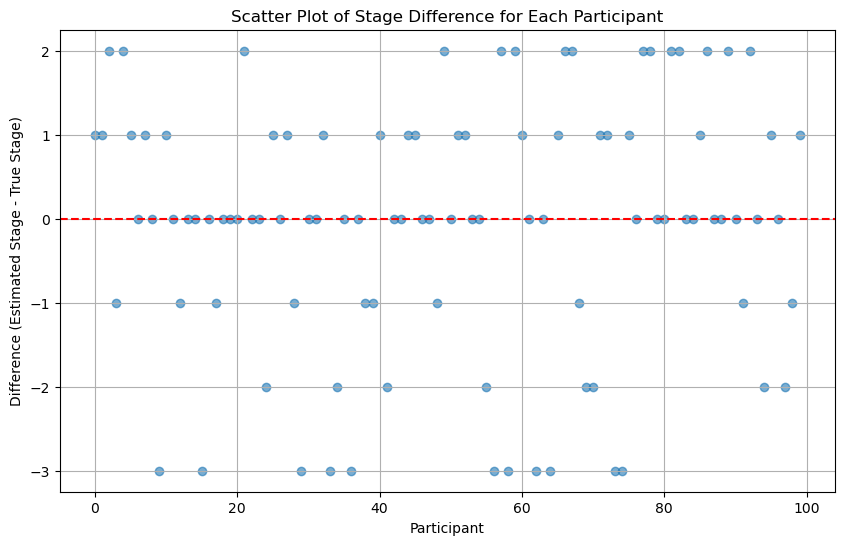

In [17]:
estimated_stages = participant_stages
actual_stages = np.array(list(actual_stage_dic.values()))
differences = estimated_stages - actual_stages
scatter_plot_of_stage_differences(differences)